In [2]:
# Cell 1: Install & imports
!pip install --quiet numpy pandas matplotlib seaborn scikit-learn tensorflow

import os, glob, zipfile, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

print("TensorFlow version:", tf.__version__)
sns.set()


TensorFlow version: 2.19.0


In [3]:
# Download & unzip UCI HAR dataset

if not os.path.exists("UCI HAR Dataset"):
    !wget -q "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip" -O "UCI_HAR.zip"
    !unzip -q UCI_HAR.zip -d .
    print("Downloaded and unzipped UCI HAR Dataset.")
else:
    print("UCI HAR Dataset already present.")


Downloaded and unzipped UCI HAR Dataset.


In [4]:
#  Build windows CSV from UCI HAR inertial signals
# UCI already provides 128-sample windows in Inertial Signals files.
base = "UCI HAR Dataset"

def load_inertial_file(path):
    return pd.read_csv(path, header=None, delim_whitespace=True)

train_dir = os.path.join(base, "train", "Inertial Signals")
test_dir  = os.path.join(base, "test",  "Inertial Signals")

# total acceleration (already windowed: each row = 128 samples)
ta_x_train = load_inertial_file(os.path.join(train_dir, "total_acc_x_train.txt"))
ta_y_train = load_inertial_file(os.path.join(train_dir, "total_acc_y_train.txt"))
ta_z_train = load_inertial_file(os.path.join(train_dir, "total_acc_z_train.txt"))
subjects_train = pd.read_csv(os.path.join(base, "train", "subject_train.txt"), header=None, names=["subject"])

ta_x_test = load_inertial_file(os.path.join(test_dir, "total_acc_x_test.txt"))
ta_y_test = load_inertial_file(os.path.join(test_dir, "total_acc_y_test.txt"))
ta_z_test = load_inertial_file(os.path.join(test_dir, "total_acc_z_test.txt"))
subjects_test = pd.read_csv(os.path.join(base, "test", "subject_test.txt"), header=None, names=["subject"])

def build_windows_df(ax_df, ay_df, az_df, subjects_series):
    n = ax_df.shape[0]
    rows = []
    for i in range(n):
        ax_vals = ax_df.iloc[i].values
        ay_vals = ay_df.iloc[i].values
        az_vals = az_df.iloc[i].values
        row = np.concatenate([ax_vals, ay_vals, az_vals])
        rows.append(row)
    columns = [f"ax_{i}" for i in range(ax_df.shape[1])] + \
              [f"ay_{i}" for i in range(ay_df.shape[1])] + \
              [f"az_{i}" for i in range(az_df.shape[1])]
    df = pd.DataFrame(rows, columns=columns)
    df["subject_id"] = subjects_series.values
    return df

train_windows = build_windows_df(ta_x_train, ta_y_train, ta_z_train, subjects_train["subject"])
test_windows  = build_windows_df(ta_x_test, ta_y_test, ta_z_test, subjects_test["subject"])
full_df = pd.concat([train_windows, test_windows], axis=0).reset_index(drop=True)

out_path = "/content/employees_30_uci_windows.csv"
full_df.to_csv(out_path, index=False)
print("Saved UCI windows CSV to:", out_path)
print("Windows shape:", full_df.shape)


/tmp/ipython-input-2575865396.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path, header=None, delim_whitespace=True)
/tmp/ipython-input-2575865396.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path, header=None, delim_whitespace=True)
/tmp/ipython-input-2575865396.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path, header=None, delim_whitespace=True)
/tmp/ipython-input-2575865396.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path, header=None, delim_whitespace=True)
/tmp/ipython-input-2575865396.py:6: 

Saved UCI windows CSV to: /content/employees_30_uci_windows.csv
Windows shape: (10299, 385)


In [8]:
# Upload your Physics Toolbox CSVs and append them

from pathlib import Path

realtime_folder = "/content/realtime_csvs"   # create this folder and upload CSVs there
Path(realtime_folder).mkdir(parents=True, exist_ok=True)
realtime_files = sorted(glob.glob(os.path.join(realtime_folder, "*.csv")))
print("Found realtime CSVs:", realtime_files)

# Edit this mapping for your uploaded filenames:
# Example: filename_to_subject = {"emp01_walk.csv": 1, "emp02_walk.csv": 2}
filename_to_subject = {
    # put your mappings here, e.g. "c33dccca-c1b5-4c75-87e9-e9d16406d65c.csv": 1
}

def convert_realtime_csv_to_windows(path, subject_id, window_size=128, step=64):
    df = pd.read_csv(path)
    # try to detect accel column names (common variants)
    candidates = {
        "ax": ["ax","acc_x","accel_x","acc_x(ms^-2)","x"],
        "ay": ["ay","acc_y","accel_y","acc_y(ms^-2)","y"],
        "az": ["az","acc_z","accel_z","acc_z(ms^-2)","z"]
    }
    def find_col(cands):
        for c in cands:
            if c in df.columns:
                return c
        return None
    ax_col = find_col(candidates["ax"])
    ay_col = find_col(candidates["ay"])
    az_col = find_col(candidates["az"])
    if ax_col is None or ay_col is None or az_col is None:
        raise ValueError(f"Could not detect accel columns in {path}. Found columns: {df.columns.tolist()}")
    ax = df[ax_col].values
    ay = df[ay_col].values
    az = df[az_col].values
    rows = []
    for start in range(0, len(ax) - window_size + 1, step):
        ax_w = ax[start:start+window_size]
        ay_w = ay[start:start+window_size]
        az_w = az[start:start+window_size]
        rows.append(np.concatenate([ax_w, ay_w, az_w]))
    cols = [f"ax_{i}" for i in range(window_size)] + [f"ay_{i}" for i in range(window_size)] + [f"az_{i}" for i in range(window_size)]
    out_df = pd.DataFrame(rows, columns=cols)
    out_df["subject_id"] = subject_id
    return out_df

# Append to UCI dataset if mapping provided
merged_df = full_df.copy()
appended_count = 0
for f in realtime_files:
    fname = os.path.basename(f)
    if fname not in filename_to_subject:
        print(f"Skipping {fname} (no mapping). Add filename->subject_id to filename_to_subject dict.")
        continue
    sid = filename_to_subject[fname]
    add_df = convert_realtime_csv_to_windows(f, sid, window_size=128, step=64)
    merged_df = pd.concat([merged_df, add_df], axis=0)
    appended_count += add_df.shape[0]
print(f"Appended {appended_count} windows from realtime CSVs.")
merged_path = "/content/employees_uci_plus_realtime_windows.csv"
merged_df.to_csv(merged_path, index=False)
print("Merged CSV saved to:", merged_path)

Found realtime CSVs: []
Appended 0 windows from realtime CSVs.
Merged CSV saved to: /content/employees_uci_plus_realtime_windows.csv


Now that the data is merged, we'll prepare it for training. This involves:

1.  Separating the features (the sensor readings) from the labels (the subject IDs).
2.  Scaling the features to a similar range, which helps machine learning models perform better.

In [ ]:
# Prepare data for modeling

# Separate features and labels
X = merged_df.drop('subject_id', axis=1)
y = merged_df['subject_id']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled features shape:", X_scaled.shape)
print("Labels shape:", y.shape)

In [9]:
# Cell 5: Load final windows CSV & prepare X,y
# By default use merged file if exists, else use UCI-only CSV
csv_path = "/content/employees_uci_plus_realtime_windows.csv"
if not os.path.exists(csv_path):
    csv_path = "/content/employees_30_uci_windows.csv"
print("Using windows CSV:", csv_path)

df = pd.read_csv(csv_path)
window_len = 128
ax_cols = [f"ax_{i}" for i in range(window_len)]
ay_cols = [f"ay_{i}" for i in range(window_len)]
az_cols = [f"az_{i}" for i in range(window_len)]
feature_cols = ax_cols + ay_cols + az_cols

# Sanity check
for c in feature_cols[:6]:
    if c not in df.columns:
        raise ValueError(f"Expected column {c} not found in CSV")

X = df[feature_cols].values
y = df["subject_id"].values.astype(int)

# reshape flattened windows to (num_windows, 128, 3)
X = X.reshape(-1, window_len, 3)
print("Final X shape (windows, timesteps, features):", X.shape, "y shape:", y.shape)

# Encode subject IDs to 0..K-1
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)
print("Number of distinct subjects (employees):", n_classes)

# split (stratified by subject)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Using windows CSV: /content/employees_uci_plus_realtime_windows.csv
Final X shape (windows, timesteps, features): (10299, 128, 3) y shape: (10299,)
Number of distinct subjects (employees): 30
Train shape: (8239, 128, 3) Test shape: (2060, 128, 3)


In [10]:
# Cell 6: Scale per-axis and build model
# We'll scale axis channels globally (fit on train samples)
nsamples, ntimesteps, nfeatures = X_train.shape
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, nfeatures)  # (nsamples*timesteps, 3)
X_train_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_flat.reshape(nsamples, ntimesteps, nfeatures)

# scale test
X_test_flat = X_test.reshape(-1, nfeatures)
X_test_flat = scaler.transform(X_test_flat)
X_test_scaled = X_test_flat.reshape(X_test.shape[0], ntimesteps, nfeatures)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)

# Build CNN+LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ntimesteps, nfeatures)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Scaled shapes: (8239, 128, 3) (2060, 128, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,310 (692.62 KB)

 Trainable params: 177,310 (692.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 3.00663, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 16s - 134ms/step - accuracy: 0.0798 - loss: 3.2088 - val_accuracy: 0.1068 - val_loss: 3.0066
Epoch 2/40

Epoch 2: val_loss improved from 3.00663 to 2.60720, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 97ms/step - accuracy: 0.1587 - loss: 2.8397 - val_accuracy: 0.2209 - val_loss: 2.6072
Epoch 3/40

Epoch 3: val_loss improved from 2.60720 to 2.53301, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 21s - 178ms/step - accuracy: 0.2301 - loss: 2.5115 - val_accuracy: 0.2646 - val_loss: 2.5330
Epoch 4/40

Epoch 4: val_loss improved from 2.53301 to 2.24352, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 12s - 100ms/step - accuracy: 0.2936 - loss: 2.2680 - val_accuracy: 0.3107 - val_loss: 2.2435
Epoch 5/40

Epoch 5: val_loss improved from 2.24352 to 1.79531, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 15s - 130ms/step - accuracy: 0.3528 - loss: 2.0410 - val_accuracy: 0.4320 - val_loss: 1.7953
Epoch 6/40

Epoch 6: val_loss improved from 1.79531 to 1.71504, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 16s - 138ms/step - accuracy: 0.3980 - loss: 1.8817 - val_accuracy: 0.4272 - val_loss: 1.7150
Epoch 7/40

Epoch 7: val_loss did not improve from 1.71504
116/116 - 11s - 94ms/step - accuracy: 0.4271 - loss: 1.7761 - val_accuracy: 0.4393 - val_loss: 1.7466
Epoch 8/40

Epoch 8: val_loss did not improve from 1.71504
116/116 - 11s - 94ms/step - accuracy: 0.4592 - loss: 1.6572 - val_accuracy: 0.4272 - val_loss: 1.7682
Epoch 9/40

Epoch 9: val_loss improved from 1.71504 to 1.65353, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 94ms/step - accuracy: 0.4770 - loss: 1.5881 - val_accuracy: 0.4393 - val_loss: 1.6535
Epoch 10/40

Epoch 10: val_loss improved from 1.65353 to 1.60294, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 20s - 171ms/step - accuracy: 0.5109 - loss: 1.4700 - val_accuracy: 0.4782 - val_loss: 1.6029
Epoch 11/40

Epoch 11: val_loss improved from 1.60294 to 1.40591, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 10s - 89ms/step - accuracy: 0.5327 - loss: 1.3792 - val_accuracy: 0.5182 - val_loss: 1.4059
Epoch 12/40

Epoch 12: val_loss did not improve from 1.40591
116/116 - 11s - 94ms/step - accuracy: 0.5434 - loss: 1.3363 - val_accuracy: 0.5109 - val_loss: 1.4434
Epoch 13/40

Epoch 13: val_loss improved from 1.40591 to 1.23243, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 21s - 178ms/step - accuracy: 0.5637 - loss: 1.2555 - val_accuracy: 0.5813 - val_loss: 1.2324
Epoch 14/40

Epoch 14: val_loss did not improve from 1.23243
116/116 - 11s - 97ms/step - accuracy: 0.5763 - loss: 1.2198 - val_accuracy: 0.5158 - val_loss: 1.4286
Epoch 15/40

Epoch 15: val_loss improved from 1.23243 to 1.22422, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 97ms/step - accuracy: 0.5705 - loss: 1.2333 - val_accuracy: 0.5752 - val_loss: 1.2242
Epoch 16/40

Epoch 16: val_loss did not improve from 1.22422
116/116 - 10s - 84ms/step - accuracy: 0.6042 - loss: 1.1355 - val_accuracy: 0.4794 - val_loss: 1.5193
Epoch 17/40

Epoch 17: val_loss improved from 1.22422 to 1.17560, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 99ms/step - accuracy: 0.6169 - loss: 1.1022 - val_accuracy: 0.5910 - val_loss: 1.1756
Epoch 18/40

Epoch 18: val_loss did not improve from 1.17560
116/116 - 11s - 98ms/step - accuracy: 0.6281 - loss: 1.0459 - val_accuracy: 0.6056 - val_loss: 1.1923
Epoch 19/40

Epoch 19: val_loss did not improve from 1.17560
116/116 - 20s - 174ms/step - accuracy: 0.6344 - loss: 1.0407 - val_accuracy: 0.5680 - val_loss: 1.2407
Epoch 20/40

Epoch 20: val_loss improved from 1.17560 to 1.11376, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 97ms/step - accuracy: 0.6417 - loss: 1.0023 - val_accuracy: 0.6092 - val_loss: 1.1138
Epoch 21/40

Epoch 21: val_loss improved from 1.11376 to 1.06436, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 11s - 93ms/step - accuracy: 0.6595 - loss: 0.9567 - val_accuracy: 0.6117 - val_loss: 1.0644
Epoch 22/40

Epoch 22: val_loss improved from 1.06436 to 0.94806, saving model to /content/gait_cnn_lstm_best.h5


116/116 - 10s - 88ms/step - accuracy: 0.6670 - loss: 0.9394 - val_accuracy: 0.6541 - val_loss: 0.9481
Epoch 23/40

Epoch 23: val_loss did not improve from 0.94806
116/116 - 11s - 98ms/step - accuracy: 0.6732 - loss: 0.8992 - val_accuracy: 0.5789 - val_loss: 1.1739
Epoch 24/40

Epoch 24: val_loss did not improve from 0.94806
116/116 - 20s - 176ms/step - accuracy: 0.6931 - loss: 0.8599 - val_accuracy: 0.5995 - val_loss: 1.2346
Epoch 25/40

Epoch 25: val_loss did not improve from 0.94806
116/116 - 20s - 175ms/step - accuracy: 0.6889 - loss: 0.8698 - val_accuracy: 0.5170 - val_loss: 1.4030
Epoch 26/40

Epoch 26: val_loss did not improve from 0.94806
116/116 - 10s - 88ms/step - accuracy: 0.6953 - loss: 0.8351 - val_accuracy: 0.6311 - val_loss: 1.0601
Epoch 27/40

Epoch 27: val_loss did not improve from 0.94806
116/116 - 12s - 99ms/step - accuracy: 0.7073 - loss: 0.8242 - val_accuracy: 0.6117 - val_loss: 1.0993
Epoch 28/40

Epoch 28: val_loss did not improve from 0.94806
116/116 - 11s - 96ms

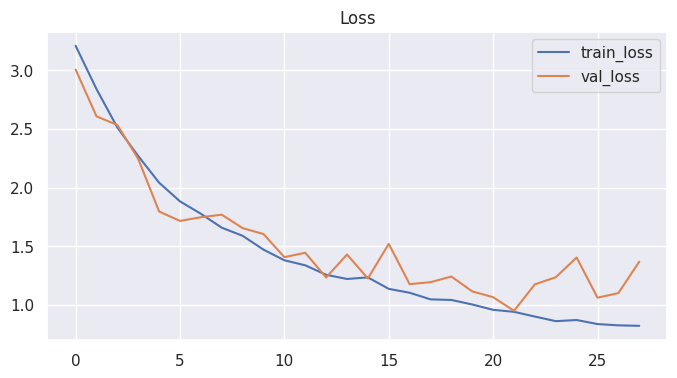

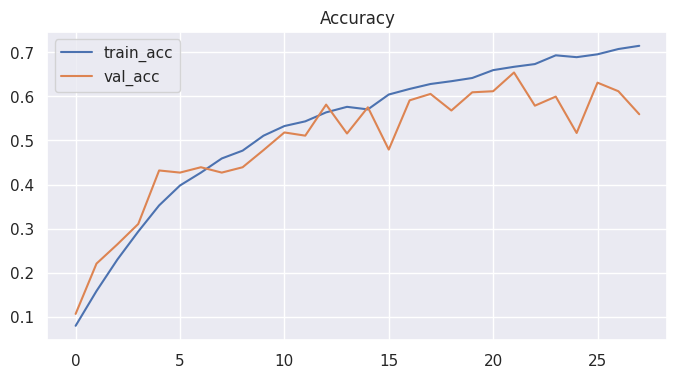

In [11]:
# Cell 7: Train with EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
ckpt_path = "/content/gait_cnn_lstm_best.h5"
mc = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=64,
    callbacks=[es, mc],
    verbose=2
)

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy"); plt.show()


Test accuracy: 0.6558252427184466

Classification report (per-subject):

              precision    recall  f1-score   support

           1       0.59      0.59      0.59        69
           2       0.61      0.52      0.56        60
           3       0.50      0.51      0.51        68
           4       0.70      0.79      0.75        63
           5       0.59      0.80      0.68        60
           6       0.91      0.60      0.72        65
           7       0.58      0.53      0.55        62
           8       0.55      0.48      0.51        56
           9       0.95      0.72      0.82        58
          10       0.88      0.75      0.81        59
          11       0.70      0.81      0.75        63
          12       0.57      0.61      0.59        64
          13       0.59      0.52      0.55        65
          14       0.68      0.63      0.66        65
          15       0.78      0.64      0.70        66
          16       0.73      0.74      0.73        73
        

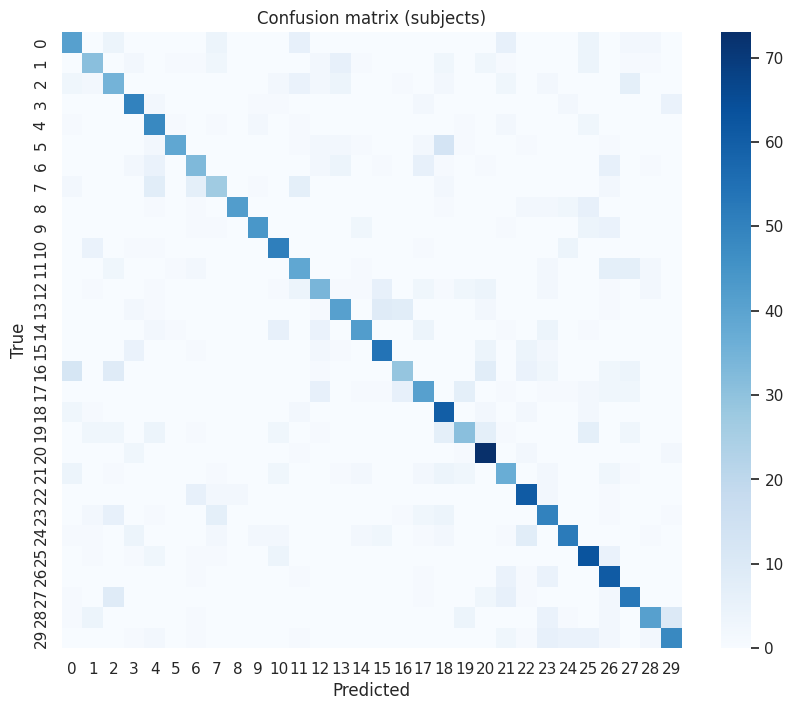

In [12]:
# Cell 8: Evaluate on test set
# Load best model weights (if saved)
if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
y_pred_probs = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report (per-subject):\n")
print(classification_report(y_test, y_pred, target_names=[str(x) for x in le.classes_]))

# Confusion matrix (may be large for 30 classes)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (subjects)")
plt.show()


In [14]:
# Cell 9: Save model & scaler & encoder
model_save_path = "/content/gait_cnn_lstm_best.h5"
model.save(model_save_path)  # saves SavedModel format
print("Saved TF model to:", model_save_path)

# Save scaler and label encoder using joblib
!pip install --quiet joblib
import joblib
joblib.dump(scaler, "/content/scaler_joblib.pkl")
joblib.dump(le, "/content/label_encoder_joblib.pkl")
print("Saved scaler and label encoder.")


Saved TF model to: /content/gait_cnn_lstm_best.h5
Saved scaler and label encoder.


In [15]:
# Cell 10: Real-time check-in helper (use when a phone uploads a 128-sample window)
import numpy as np, joblib
scaler = joblib.load("/content/scaler_joblib.pkl")
le = joblib.load("/content/label_encoder_joblib.pkl")
# model already loaded

def check_in_from_raw_window(raw_window, threshold=0.6):
    """
    raw_window: numpy array shape (128,3) in same units as training windows (ax,ay,az)
    threshold: confidence threshold to allow access
    """
    if raw_window.shape != (ntimesteps, nfeatures):
        raise ValueError(f"raw_window must be shape {(ntimesteps, nfeatures)}")
    scaled = scaler.transform(raw_window.reshape(-1,3)).reshape(1, ntimesteps, nfeatures)
    probs = model.predict(scaled)[0]
    idx = np.argmax(probs)
    prob = probs[idx]
    subj_label = le.inverse_transform([idx])[0]
    if prob >= threshold:
        print(f"✅ ACCESS GRANTED -> subject {subj_label} (confidence {prob:.2f})")
    else:
        print(f"❌ ACCESS DENIED -> top={subj_label}, conf={prob:.2f} < {threshold}")
    return subj_label, float(prob)

# Demo with a random test window
rand_idx = np.random.randint(0, X_test.shape[0])
demo_raw = X_test[rand_idx]  # raw (not scaled)
check_in_from_raw_window(demo_raw, threshold=0.65)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
❌ ACCESS DENIED -> top=26, conf=0.28 < 0.65


(np.int64(26), 0.2829727530479431)